In [1]:
%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

from typing import Tuple, Dict, Optional

import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import jaxley as jx
from jaxley import Compartment

from jaxley_mech.channels.fm97 import Na, K, KA, KCa, Ca, CaNernstReversal, Leak, CaPump
from jaxley_mech.utils import prettify


## Voltage Clamp

In [2]:
params = {
    # conductance
    "Na_gNa": 50e-3, # 0.05 in the paper, 0.04 in the code 
    "K_gK": 12e-3,
    "KA_gKA": 36e-3,
    "Ca_gCa": 2.2e-3,
    "KCa_gKCa": 0.05e-3,
    "Leak_gLeak": 0.05e-3,

    # reversal potential
    "Na_eNa": 35,
    "Leak_eLeak": -65,

    # Ca dynamics
    "Cao": 1.8,

    # pump
    "CaPump_taur": 10.,
    "CaPump_cainf": 0.0001,

    # global
    "length": 25.,
    "radius": 25/2, 
    "eK": -75,
    "v": -65,
}

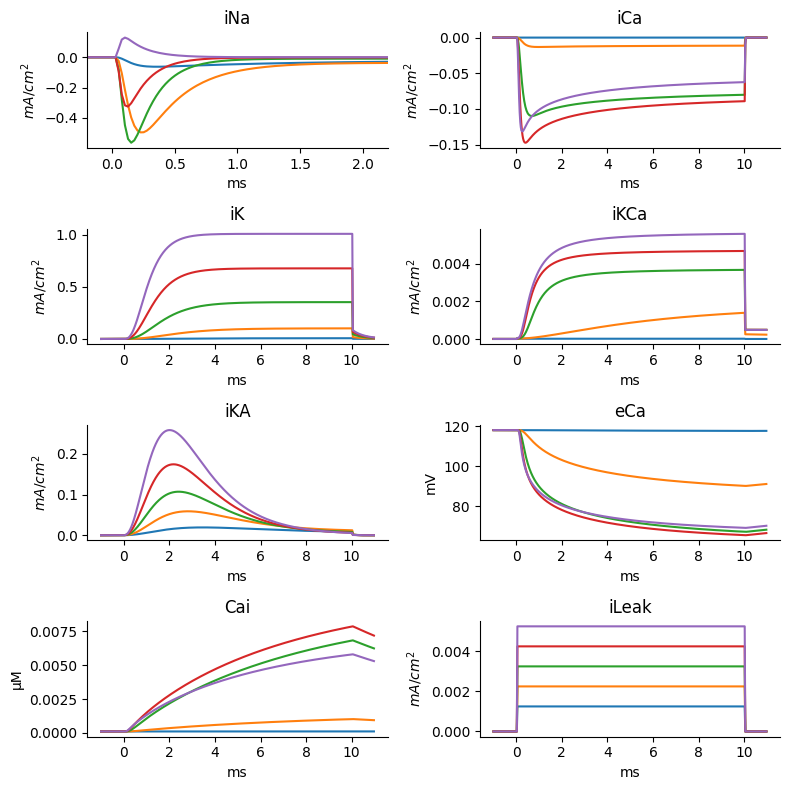

In [3]:
to_records = ["iNa", "iCa", "iK", "iKCa", "iKA", "eCa", 'Cai', "iLeak"]
mosaic = [["iNa", "iCa"], ["iK", "iKCa"], ['iKA', 'eCa'], ["Cai", "iLeak"]]

fig, ax = plt.subplot_mosaic(mosaic, figsize=(8, 8))

V_steps = [-40, -20, 0, 20, 40]

# rename K currents, otherwise they will be iK
kca = KCa()
kca.current_name = "iKCa"

ka = KA()
ka.current_name = "iKA"

for v_step in V_steps:

    cell = Compartment()

    cell.insert(Na())
    cell.insert(Ca())
    cell.insert(K())
    cell.insert(kca)
    cell.insert(ka)
    cell.insert(CaNernstReversal())
    cell.insert(CaPump())
    cell.insert(Leak())

    for name, param in params.items():
        cell.set(name, param)

    cell.init_states()

    for rec in to_records:
        cell.record(rec, verbose=False)

    pre_vc_time = 50  # ms
    vc_on_time =  10 # ms
    total_time = 100 # ms
    dt = 0.025 # 
    time_steps = int(total_time // dt + 1)
    time = jnp.linspace(0, total_time, time_steps)

    v = jnp.zeros(time_steps) - 65
    vc_on = int(pre_vc_time / dt)
    vc_off = int((pre_vc_time + vc_on_time) / dt)
    padding = int(1/dt)
    v = v.at[vc_on:vc_off].set(v_step)
    cell.clamp("v", v, verbose=False)

    s = jx.integrate(cell, delta_t=dt, t_max=total_time)
    s = prettify(s, to_records, dt)

    for i, rec in enumerate(to_records):
        ax[rec].plot((s["time"]-pre_vc_time)[vc_on-padding:vc_off+padding], s[rec][vc_on-padding:vc_off+padding])
        ax[rec].set_title(rec)
        ax[rec].spines["top"].set_visible(False)
        ax[rec].spines["right"].set_visible(False)
        if rec == "Cai":
            ax[rec].set_ylabel("μM")
        elif rec == "iNa":
            ax[rec].set_xlim(-0.2, 2.2)
            ax[rec].set_ylabel(r"$mA/cm^2$")
        elif rec == "eCa":
            ax[rec].set_ylabel("mV")
        else:
            ax[rec].set_ylabel(r"$mA/cm^2$")
        
        ax[rec].set_xlabel("ms")

fig.tight_layout()

The values (Na and Ca) are still a bit off compared to Fig. 1 in Fohlmeister & Miller (1997). It is primarily due to the parameters reported in Table 1 are not exactly the same one used in the working NEURON code, which is in turn different from the current version hosted on [ModelDB](https://modeldb.science/3673). I have to manually adjust the parameters to get the similar results as in the paper.

The other possible source of discrepancy might stem from the convenient implementation of the built-in Calcium pump in the Calcium channel, while the NEURON implementation relies on a separate Calcium pump (which is again implemented differently from the description in the paper). 

## Current Clamp

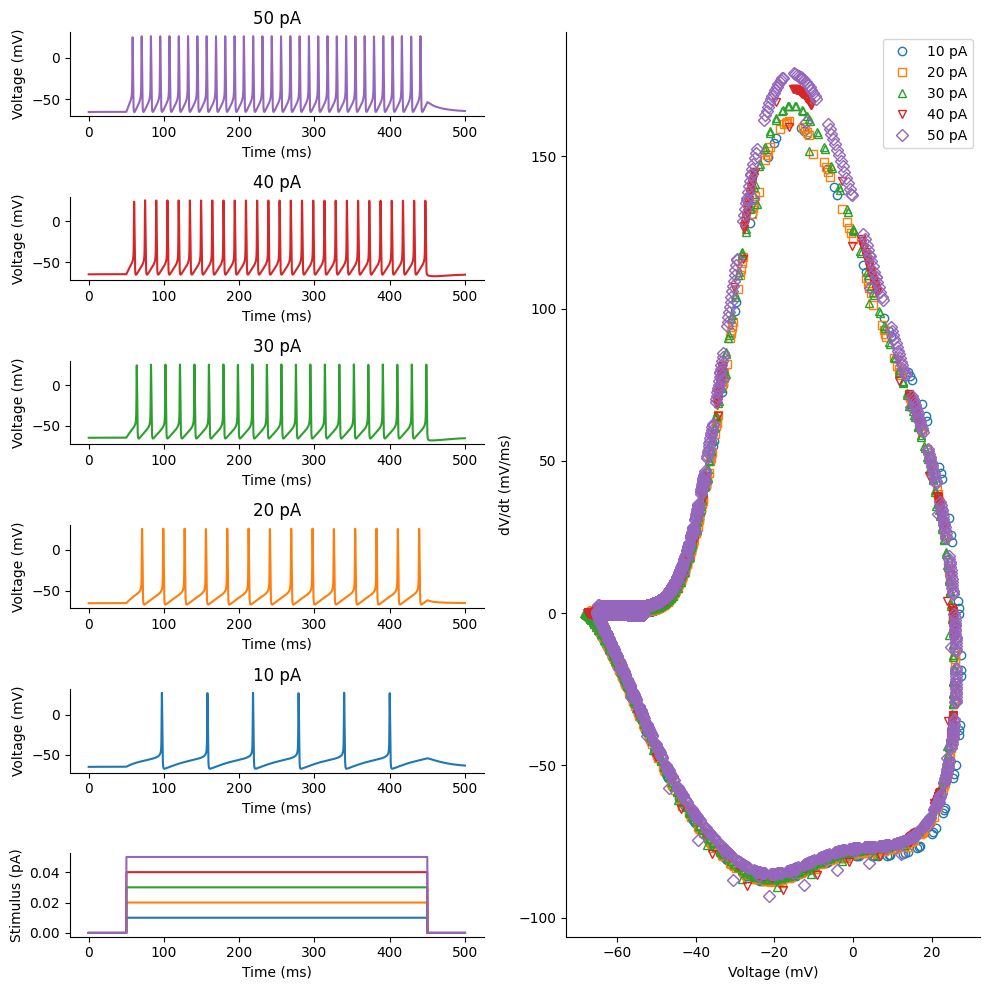

In [4]:
# Fig. 4

# Stimulus.
i_delay = 50.0  # ms
i_dur = 400.0  # ms
i_offset = 0.0

# Duration and step size.
dt = 0.1  # ms
t_max = i_dur + 2 * i_delay  # ms

time_vec = jnp.arange(0.0, t_max+dt, dt)

mosaic = """
    AAAAAGGGGG
    BBBBBGGGGG
    CCCCCGGGGG
    DDDDDGGGGG
    EEEEEGGGGG
    FFFFFGGGGG
"""
mappings = {
    0: "E",
    1: "D",
    2: "C",
    3: "B",
    4: "A",
    5: "F",
    6: "G",
}
markers = {
    4: "D",
    3: "v",
    2: "^",
    1: "s",
    0: "o",
}

fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(10, 10))

for j, i_amp in enumerate([0.01, 0.02, 0.03, 0.04, 0.05]): 

    cell = Compartment()

    cell.insert(Na())
    cell.insert(Ca())
    cell.insert(K())
    cell.insert(KCa())
    cell.insert(KA())
    cell.insert(CaNernstReversal())
    cell.insert(CaPump())
    cell.insert(Leak())

    for name, param in params.items():
        cell.set(name, param)

    current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max, i_offset=i_offset)
    cell.stimulate(current, verbose=False)
    cell.record(verbose=False)

    # run the model
    s = jx.integrate(cell, delta_t=dt)

    _ = ax[mappings[j]].plot(time_vec, s.T[:-1], label=f"{int(i_amp*1000)} pA", color=f"C{j}")
    _ = ax[mappings[j]].set_xlabel("Time (ms)")
    _ = ax[mappings[j]].set_ylabel("Voltage (mV)")
    _ = ax[mappings[j]].set_title(f"{int(i_amp*1000)} pA")
    _ = ax[mappings[j]].spines["top"].set_visible(False)
    _ = ax[mappings[j]].spines["right"].set_visible(False)

    _ = ax["F"].plot(time_vec, current, label=f"{int(i_amp*1000)} pA")
    _ = ax["F"].set_xlabel("Time (ms)")
    _ = ax["F"].set_ylabel("Stimulus (pA)")
    _ = ax["F"].spines["top"].set_visible(False)
    _ = ax["F"].spines["right"].set_visible(False)

    dvdt = jnp.diff(s.T.flatten()) / dt
    _ = ax["G"].plot(s.T.flatten()[:-1], dvdt, marker=markers[j], markerfacecolor='None', linestyle='None', label=f"{int(i_amp*1000)} pA", color=f"C{j}")
    _ = ax["G"].set_xlabel("Voltage (mV)")
    _ = ax["G"].set_ylabel("dV/dt (mV/ms)")
    _ = ax["G"].spines["top"].set_visible(False)
    _ = ax["G"].spines["right"].set_visible(False)

ax["G"].legend()
fig.tight_layout()

In [5]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p jaxley_mech

Last updated: 2024-10-23 20:44:23CEST

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.21.0

jaxley_mech: 0.2.1

jax       : 0.4.35
jaxley    : 0.4.0
matplotlib: 3.9.2

Watermark: 2.4.3

